# MIMIC ML/DL

AI IN HEALTHCARE-WB 54315 Tutorial

## Predicting ICU Transfer from Admission Data

### Practical Purpose

Given information available at hospital admission time, predict whether the patient will require ICU care during that hospital stay.

### Learning Goal

Get familiar with the machine learning and deep learning technologies and know how to apply them to analyze EHR data and derive insights

### Dataset

[MIMIC-IV](https://physionet.org/content/mimiciv/3.1/) (requires credentials to access)

### ML/DL Models

LogisticRegression, MLP

## Step 1 - Data Extraction and Labeling

### Objective

Import the relevant data → Prepare and label for training

### Result

Collection of admission events, labeled by whether or not an ICU stay followed:
- Positive (1): admissions including at least one ICU stay
- Negative (0): admission never transfers to ICU

In [42]:
MIMIC_IV = '../mimic-iv'
RANDOM_SEED = 42

import pandas as pd
admissions = pd.read_csv(f"{MIMIC_IV}/admissions.csv.gz")
patients   = pd.read_csv(f"{MIMIC_IV}/patients.csv.gz")
icustays   = pd.read_csv(f"{MIMIC_IV}/icustays.csv.gz")

# build cohort and label
#   one row per hospital admission y=1 if admission ever appears in ICU stay, y=0 otherwise

# start by labeling every admission in ICU as 1
icu_labeled = icustays[["hadm_id"]].drop_duplicates().assign(y=1)
icu_labeled.head()

# merge labeled ICU into admissions and fill missing values with 0
cohort = (
    admissions.merge(icu_labeled, on="hadm_id", how="left")
              .assign(y=lambda df: df["y"].fillna(0).astype(int))
)

### Evaluate Labels

In [43]:
# so now any admission that appears in the ICU stay is labeled as 1, otherwise it is a 0
# let's take a look at the distribution
cohort["y"].value_counts()


y
0    460786
1     85242
Name: count, dtype: int64

## Step 2 - Feature Engineering

### Add Age and Gender from Patients Table

In [44]:
# add some basic demographic information to the cohort from the patients table
# most of the other demographic info was already in the admissions table
patients.describe()
cohort = cohort.merge(
    patients[["subject_id", "anchor_age", "gender"]],
    on="subject_id",
    how="left"
)

### Keep First Admission for a Patient

In [45]:
# to simplify and avoid multiple correlated samples for the same patient keep
# only the first admission per patient
cohort = (
    cohort.sort_values(["subject_id", "admittime"])
    .drop_duplicates("subject_id", keep="first")
)
cohort["y"].value_counts()

y
0    179533
1     43919
Name: count, dtype: int64

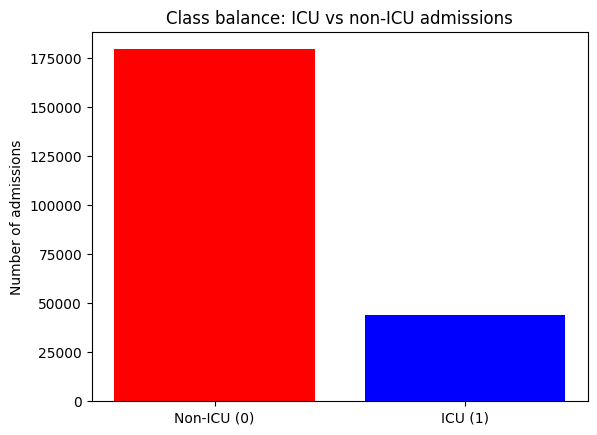

y
0    0.803452
1    0.196548
Name: proportion, dtype: float64

In [46]:
# Visualize the distribution of the labels
import matplotlib.pyplot as plt

class_counts = cohort["y"].value_counts().sort_index()
plt.figure()
plt.bar(["Non-ICU (0)", "ICU (1)"], class_counts.values, color=["#ff0000", "#0000ff"])
plt.title("Class balance: ICU vs non-ICU admissions")
plt.ylabel("Number of admissions")
plt.show()
cohort["y"].value_counts(normalize=True)


### Choose Features

Initially, keep the feature set deliberately small and interpretable:

**Numeric feature**:

- anchor_age (age)

**Categorical features**:

- gender
- admission_type (EMERGENCY, ELECTIVE, URGENT, etc.)
- admission_location (ED, transfer from other hospital, clinic, …)
- insurance (Medicare, Medicaid, Private, Self Pay, …)
- race (broad categories)
- language (English, Spanish, French, etc.)
- marital_status (Single, Married, Divorced, Widowed, etc.)

In [47]:
num_cols = ["anchor_age"]
cat_cols = [
    "gender",
    "admission_type",
    "admission_location",
    "insurance",
    "race",
    "language",
    "marital_status",
]
features = num_cols + cat_cols

data = cohort[["hadm_id", "y"] + features].copy()
data.head()


,hadm_id,y,anchor_age,gender,admission_type,admission_location,insurance,race,language,marital_status
0,22595853,0,52,F,URGENT,TRANSFER FROM HOSPITAL,Medicaid,WHITE,English,WIDOWED
4,25022803,0,19,F,EU OBSERVATION,EMERGENCY ROOM,NaN,WHITE,English,SINGLE
5,23052089,0,72,M,EW EMER.,WALK-IN/SELF REFERRAL,Medicare,WHITE,English,MARRIED
7,27250926,0,25,M,EU OBSERVATION,EMERGENCY ROOM,NaN,WHITE,English,SINGLE
8,22927623,0,48,F,EU OBSERVATION,EMERGENCY ROOM,Medicaid,WHITE,English,DIVORCED


### Handle Missing Features

- `insurance` -> "NONE"
- `language` -> "English" (assume not noting language means not noteworthy)
- `marital_status` -> "Unknown"
- `admission_location` -> "TRANSFER FROM HOSPITAL" (determined to be most likely for 1 row with missing value)

In [48]:
# call missing insurance "NONE"
data["insurance"] = data["insurance"].fillna("NONE")
# assuming missing language means English
data["language"] = data["language"].fillna("English")
data["language"].value_counts()

# call missing marital status and religion "Unknown"
data["marital_status"] = data["marital_status"].fillna("Unknown")
data["marital_status"].value_counts()

# there's a single row with a missing admission location. It's admission type
# is "URGENT, so assume it was a TRANSFER FROM HOSPITAL, since that is the 
# location most often associated with urgent admissions
data[data["admission_location"].isna()]
data[data["admission_type"] == "URGENT"]["admission_location"].value_counts()
data["admission_location"] = data["admission_location"].fillna("TRANSFER FROM HOSPITAL")

data[features].isna().sum()

anchor_age            0
gender                0
admission_type        0
admission_location    0
insurance             0
race                  0
language              0
marital_status        0
dtype: int64

### One-hot Encode Categorical Features

And cast booleans to 1.0 or 0.0 to make them easier to work with later

In [49]:
X = pd.get_dummies(data[features], columns=cat_cols, dummy_na=False)

# cast age to float, since we will normalize after splitting
# cast one-hot encoded columns to float, since our MLP model expects that
X = X.astype("float64")

y = data["y"].values
hadm_ids = data["hadm_id"].values

X.shape, y.shape



((223452, 92), (223452,))

### Split Dataset

Using a 70/30 split for training and validation - and a 50/50 split for validation and testing

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp, hadm_train, hadm_temp = train_test_split(
    X, y, hadm_ids,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=y
)

X_val, X_test, y_val, y_test, hadm_val, hadm_test = train_test_split(
    X_temp, y_temp, hadm_temp,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape
y_train.shape, y_val.shape, y_test.shape


((156416,), (33518,), (33518,))

### Standardize Age

For MLPs, it’s good practice to scale numeric features. We only have one numeric column

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# apply to each split individually, so information doesn't leak from
# test and validation sets into training
scaler.fit(X_train[num_cols])

X_train[num_cols].info()
X_train.head()

# apply to each split
for df in (X_train, X_val, X_test):
    df.loc[:, num_cols] = scaler.transform(df[num_cols])



<class 'pandas.core.frame.DataFrame'>
Index: 156416 entries, 373550 to 504811
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   anchor_age  156416 non-null  float64
dtypes: float64(1)
memory usage: 2.4 MB


## Train Logistic Regression Model

Before jumping into the deep learning model, build and evaluate a simple baseline model for comparison

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)
log_reg.fit(X_train, y_train)

# validation performance
val_probs_lr = log_reg.predict_proba(X_val)[:, 1]
val_auc_lr = roc_auc_score(y_val, val_probs_lr)
val_ap_lr  = average_precision_score(y_val, val_probs_lr)

print(f"Logistic Regression - Val ROC AUC: {val_auc_lr:.3f}, AP: {val_ap_lr:.3f}")


Logistic Regression - Val ROC AUC: 0.818, AP: 0.531


## Train Multilayer Perceptron

### Prepare data with simple container

Use container to create loaders

In [53]:
import torch
from torch.utils.data import Dataset, DataLoader

# create a small Dataset class for the training data
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# create datasets and loaders for each split
batch_size = 64

train_ds = TabularDataset(X_train.to_numpy(), y_train)
val_ds   = TabularDataset(X_val.to_numpy(), y_val)
test_ds  = TabularDataset(X_test.to_numpy(), y_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


### Define MLP

A simple Multilayer Perceptron (MLP) model with two ReLU hidden layers

In [61]:
# use a simple MLP model with two hidden layers
# Input -> 2 hidden layers -> output
# Dropout + BatchNorm to help generalization

input_dim = X_train.shape[1]

class MLP(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            
            torch.nn.Linear(128, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            
            torch.nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x).squeeze(1)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim).to(device)

### Training Loop

Train for a fixed number of epochs and track validation AUC


In [62]:
import numpy as np
import copy

def evaluate(model, loader):
    model.eval()
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            all_probs.append(probs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
            
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)
    
    auc = roc_auc_score(all_targets, all_probs)
    ap  = average_precision_score(all_targets, all_probs)
    return auc, ap, all_probs, all_targets

n_epochs = 20
best_val_auc = 0.0
best_state_dict = None

criterion = torch.nn.BCEWithLogitsLoss()  # combines sigmoid + BCE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * X_batch.size(0)
    
    epoch_loss /= len(train_ds)
    
    val_auc, val_ap, _, _ = evaluate(model, val_loader)
    
    print(f"Epoch {epoch:02d} | Train Loss: {epoch_loss:.4f} | "
          f"Val ROC AUC: {val_auc:.3f} | Val AP: {val_ap:.3f}")
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state_dict = copy.deepcopy(model.state_dict())

# load the best model weights
model.load_state_dict(best_state_dict)


Epoch 01 | Train Loss: 0.3827 | Val ROC AUC: 0.826 | Val AP: 0.552
Epoch 02 | Train Loss: 0.3735 | Val ROC AUC: 0.829 | Val AP: 0.557
Epoch 03 | Train Loss: 0.3729 | Val ROC AUC: 0.829 | Val AP: 0.555
Epoch 04 | Train Loss: 0.3713 | Val ROC AUC: 0.830 | Val AP: 0.557
Epoch 05 | Train Loss: 0.3707 | Val ROC AUC: 0.830 | Val AP: 0.558
Epoch 06 | Train Loss: 0.3703 | Val ROC AUC: 0.830 | Val AP: 0.557
Epoch 07 | Train Loss: 0.3702 | Val ROC AUC: 0.830 | Val AP: 0.558
Epoch 08 | Train Loss: 0.3694 | Val ROC AUC: 0.830 | Val AP: 0.559
Epoch 09 | Train Loss: 0.3690 | Val ROC AUC: 0.831 | Val AP: 0.560
Epoch 10 | Train Loss: 0.3692 | Val ROC AUC: 0.831 | Val AP: 0.560
Epoch 11 | Train Loss: 0.3685 | Val ROC AUC: 0.831 | Val AP: 0.559
Epoch 12 | Train Loss: 0.3682 | Val ROC AUC: 0.830 | Val AP: 0.559
Epoch 13 | Train Loss: 0.3680 | Val ROC AUC: 0.830 | Val AP: 0.558
Epoch 14 | Train Loss: 0.3674 | Val ROC AUC: 0.830 | Val AP: 0.558
Epoch 15 | Train Loss: 0.3677 | Val ROC AUC: 0.830 | Val AP: 0

<All keys matched successfully>

### Compute ROC AUC and AP against test set

In [63]:
# compute the test metrics
test_auc, test_ap, test_probs, test_targets = evaluate(model, test_loader)
print(f"Test ROC AUC: {test_auc:.3f}")
print(f"Test Average Precision: {test_ap:.3f}")

# compare with logistic regression
test_probs_lr = log_reg.predict_proba(X_test)[:, 1]
test_auc_lr = roc_auc_score(y_test, test_probs_lr)
test_ap_lr  = average_precision_score(y_test, test_probs_lr)

print(f"Logistic Regression - Test ROC AUC: {test_auc_lr:.3f}, AP: {test_ap_lr:.3f}")


Test ROC AUC: 0.827
Test Average Precision: 0.552
Logistic Regression - Test ROC AUC: 0.815, AP: 0.518


### Plot Curves

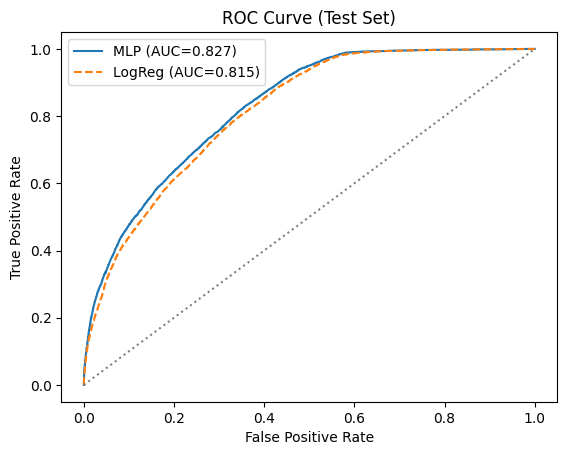

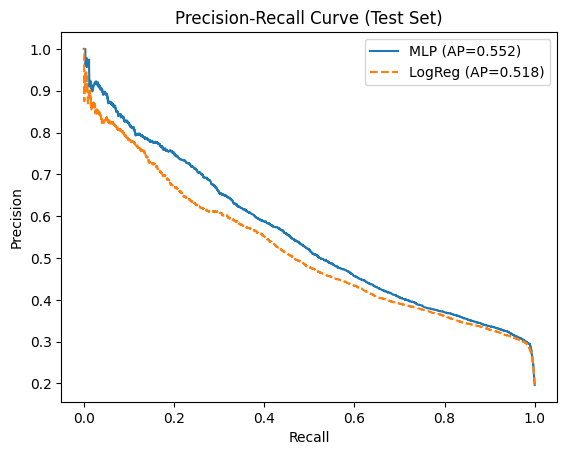

In [65]:
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC curve
fpr_dl, tpr_dl, _ = roc_curve(test_targets, test_probs)
fpr_lr, tpr_lr, _ = roc_curve(y_test, test_probs_lr)

plt.figure()
plt.plot(fpr_dl, tpr_dl, label=f"MLP (AUC={test_auc:.3f})")
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={test_auc_lr:.3f})", linestyle="--")
plt.plot([0, 1], [0, 1], color="grey", linestyle=":")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.show()

# Precision-Recall
prec_dl, rec_dl, _ = precision_recall_curve(test_targets, test_probs)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, test_probs_lr)

plt.figure()
plt.plot(rec_dl, prec_dl, label=f"MLP (AP={test_ap:.3f})")
plt.plot(rec_lr, prec_lr, label=f"LogReg (AP={test_ap_lr:.3f})", linestyle="--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test Set)")
plt.legend()
plt.show()



In [66]:
from sklearn.metrics import classification_report
threshold = 0.5
test_pred_labels = (test_probs >= threshold).astype(int)

print(classification_report(test_targets, test_pred_labels, target_names=["Non-ICU", "ICU"]))



              precision    recall  f1-score   support

     Non-ICU       0.84      0.97      0.90     26930
         ICU       0.70      0.25      0.37      6588

    accuracy                           0.83     33518
   macro avg       0.77      0.61      0.64     33518
weighted avg       0.82      0.83      0.80     33518

